# DBN Structure Inference

The idea is to infer a posterior for the *structure* of a Dynamic Bayesian Network (DBN), given some data.

We formulate this task with the following model:

$$ P(G | X) \propto P(X | G) \cdot P(G) $$

* $P(G)$ is a prior distribution over DBN structures. We'll assume it has the form
$$P(G) \propto \exp \left( -\lambda |G \setminus G^\prime| \right)$$
where $|G \setminus G^\prime|$ denotes the number of edges in the graph, which are not present in some reference graph $G^\prime$.
* $P(X | G)$ is the marginal likelihood of the DBN structure. That is, it's the likelihood of the DBN after the network parameters have been integrated out -- it scores network *structure*. 
* If we assume some reasonable priors for network parameters, $P(X|G)$ can be obtained in closed form. In this work, we'll use the following marginal likelihood:
    
    $$P(X | G) \propto \prod_{i=1}^p (1 + n)^{-(2^{|\pi(i)|} - 1)/2} \left( X_i^{+ T} X_i^+ - \frac{n}{n+1} X_i^{+ T} B_i (B_i^T B_i)^{-1} B_i^T X_i^+ \right)^{-\frac{n}{2}}$$ 
    where $X$ and $B$ are matrices obtained from data; and $n$ is the total number of timesteps in the dataset. This marginal likelihood results from an empirical prior over the regression coefficients, and an improper ($\propto 1/\sigma^2$) prior for the regression "noise" variables.

In [1]:
include("DiGraph.jl")
using Gen
using Plots
Plots.pyplot()
using .DiGraphs
using LinearAlgebra
using CSV
using DataFrames
using LRUCache
using Combinatorics

┌ Info: Recompiling stale cache file /home/dmerrell/.julia/compiled/v1.2/Gen/OEZG1.ji for Gen [ea4f424c-a589-11e8-07c0-fd5c91b9da4a]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /home/dmerrell/.julia/compiled/v1.2/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /home/dmerrell/.julia/compiled/v1.2/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /home/dmerrell/.julia/compiled/v1.2/CSV/HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1240


## Get some data

For now, we'll work with some data used by Hill et al. in their 2007 paper, _Bayesian Inference of Signaling Network Topology in a Cancer Cell Line_.

It gives the differential phosphorylation levels of 20 proteins, in a cancer cell line perturbed by EGF. This is a well-studied signaling pathway; the goal is to produce a graph describing the dependencies between proteins in this pathway. 

In [2]:
protein_names = CSV.read("data/protein_names.csv");
protein_vec = convert(Matrix, protein_names)[:,1];
protein_vec = [name[3:length(name)-2] for name in protein_vec]
reference_adjacency = CSV.read("data/prior_graph.csv");
adj_mat = convert(Matrix, reference_adjacency);
timesteps = CSV.read("data/time.csv");
timeseries_data = CSV.read("data/mukherjee_data.csv");

NOTE: I have confirmed that the ordering of proteins in `protein_vec` is identical to the ordering in the columns of `timeseries_data`. So we can depend on that.

In [3]:
function timeseries_preprocess!(timeseries_df)
    timeseries_data.condition = [ split(s, " ")[2] for s in timeseries_data[!, :Column1] ]
    timeseries_data.time = [ parse(Float64, split(s, " ")[4][2:end]) for s in timeseries_data[!, :Column1]]
    timeseries_data.replicate = [tryparse(Int64, split(s, " ")[6][2:end-1]) for s in timeseries_data[!, :Column1]]
    
    gp = DataFrames.groupby( timeseries_data, [:condition; :replicate])
    ts_vec = [convert(Matrix, g)[:,2:end-3] for g in gp]
    ts_vec = [convert(Matrix{Float64}, m) for m in ts_vec]
    
    return ts_vec
end

timeseries_preprocess! (generic function with 1 method)

In [4]:
function build_reference_graph(vertices::Vector{T}, reference_adj::Array{Int,2}) where T
    dg = DiGraph{T}()
    for i=1:size(reference_adj)[1]
        for j=1:size(reference_adj)[2]
            if reference_adj[i,j] == 1
                add_edge!(dg, vertices[i], vertices[j])
            end
        end
    end
    return dg
end;

In [5]:
reference_dg = build_reference_graph(collect(1:length(protein_vec)), adj_mat);

In [6]:
ts_vec = timeseries_preprocess!(timeseries_data);

## Build the model

Implement the graph prior distribution:

$$P(G) \propto \exp \left( -\lambda |G \setminus G^\prime| \right)$$

In [7]:
struct GraphPrior <: Gen.Distribution{DiGraph} end
const graphprior = GraphPrior()

Gen.random(gp::GraphPrior, lambda::Float64, reference_graph::DiGraph) = reference_graph

function graph_edge_diff(g::DiGraph, g_ref::DiGraph)
    e1 = Set([g.edges[i,:] for i=1:size(g.edges)[1]])
    e_ref = Set([g_ref.edges[i,:] for i=1:size(g_ref.edges)[1]])
    return length(setdiff(e1, e_ref))
end
    
Gen.logpdf(gp::GraphPrior, graph::DiGraph, lambda::Float64, reference_graph::DiGraph) = -lambda * graph_edge_diff(graph, reference_graph)

graphprior(lambda::Float64, reference_graph::DiGraph) = Gen.random(graphprior, lambda, reference_graph);

Implement the DBN's marginal distribution:

$$P(X | G) \propto \prod_{i=1}^p (1 + n)^{-(2^{|\pi(i)|} - 1)/2} \left( X_i^{+ T} X_i^+ - \frac{n}{n+1} X_i^{+ T} B_i (B_i^T B_i)^{-1} B_i^T X_i^+ \right)^{-\frac{n}{2}}$$

Some things to note:
* We're kind of shoe-horning this marginal likelihood into Gen. The probabilistic programming ethos entails modeling the entire data-generating process. This ought to provide better performance during inference, though.

A BUNCH OF HELPER FUNCTIONS:

In [27]:
# We use a few levels of LRU caching to reduce redundant computation.
const TENMB = 10000000

# Top level: store computed log-marginal likelihoods: log P(x_i | parents(x_i))
lp_cache = LRU{Vector{Int64}, Float64}(maxsize=10*TENMB, by=Base.summarysize)

# Middle level: store the value of B inv(B^T B) B^T; 
# may be reused when different children have the same parents. 
B2invconj_cache = LRU{Vector{Int64},Array{Float64,2}}(maxsize=100*TENMB, by=Base.summarysize)

# Bottom level: store B columns. B columns may be reused by different B matrices
# (so caching may be useful). But the number of possible columns is
# enormous, so an LRU policy is called for.
B_col_cache = LRU{Vector{Int64},Vector{Float64}}(maxsize=100*TENMB, by=Base.summarysize)


function compute_B_col(inds::Vector{Int64}, Xminus)
    return prod(Xminus[:,inds], dims=2)[:,1]
end


function construct_B(parent_inds::Vector{Int64}, Xminus::Array{Float64,2}, deg_max::Int64)
    
    n_cols = sum([binomial(length(parent_inds), k) for k=1:deg_max])
    B = zeros(size(Xminus)[1], n_cols)
    
    col = 1
    for deg=1:deg_max
        for comb in Combinatorics.combinations(parent_inds, deg)
            B[:,col] = get!(B_col_cache, comb) do
                return compute_B_col(comb, Xminus)  
            end 
            col += 1
        end
    end
    return B
end


function construct_B2invconj(parent_inds::Vector{Int64}, Xminus::Array{Float64,2}, deg_max::Int64)
    if length(parent_inds) == 0
        return Matrix{Float64}(I, size(Xminus)[1], size(Xminus)[1])
    end
    B = construct_B(parent_inds, Xminus, deg_max)
    B2inv = LinearAlgebra.inv(LinearAlgebra.Symmetric(transpose(B) * B + 0.01*I))
    return B * (B2inv * transpose(B))
end


function combine_X(X::Vector{Array{Float64,2}})
    
    len = sum([size(x)[1] - 1 for x in X])
    wid = size(X[1])[2]

    Xminus = zeros(len, wid)
    Xplus = zeros(len, wid)
    
    l_ind = 1
    for x in X
        r_ind = l_ind + size(x)[1] - 2
        Xminus[l_ind:r_ind, :] = x[1:size(x)[1]-1, :]
        Xplus[l_ind:r_ind, :] = x[2:size(x)[1], :]
        l_ind = r_ind + 1
    end

    return Xminus, Xplus
end


function log_marg_lik(ind::Int64, parent_inds::Vector{Int64}, 
                      Xminus::Array{Float64,2}, Xplus::Array{Float64,2}, deg_max::Int64)

    B2invconj = get!(B2invconj_cache, parent_inds) do
        construct_B2invconj(parent_inds, Xminus, deg_max)
    end
    Xp = Xplus[:, ind] 
    n = size(Xplus)[1]
    width = size(Xplus)[2]
    Bwidth = sum([Base.binomial(width, i) for i=1:deg_max])
    
    #println("IND: ", ind, "\tPARENTS: ", parent_inds)
    #println("XP^T XP = ", dot(Xp, Xp), "\tXp^T B2invconj Xp = ", (1.0*n/(n+1))*dot( Xp, B2invconj * Xp))
    return -0.5*Bwidth*log(1.0 + n) - 0.5*n*log( dot(Xp,Xp) - (1.0*n/(n+1))*dot( Xp, B2invconj * Xp))   
    
end

function get_parent_vecs(graph::DiGraph, vertices)
    return [convert(Vector{Int64}, sort([indexin([n], vertices)[1] for n in in_neighbors(graph, v)])) for v in vertices]
end

get_parent_vecs (generic function with 1 method)

THE MARGINAL LIKELIHOOD DISTRIBUTION

In [28]:
struct DBNMarginal <: Gen.Distribution{Vector{Array{Float64,2}}} end
const dbnmarginal = DBNMarginal()

"""
DBNMarginal's sampling method does nothing.
In our inference task, the Xs will always be observed.
"""
Gen.random(dbnm::DBNMarginal, parents::Vector{Vector{T}}, Xminus::Array{Float64,2}, Xplus::Array{Float64,2}, deg_max::Int64) where T = [zeros(length(parents), length(Xminus))]

dbnmarginal(parents, Xminus, Xplus, deg_max) = Gen.random(dbnmarginal, parents, Xminus, Xplus, deg_max)


"""
DBNMarginal's log_pdf, in effect, returns a score for the 
network topology. We use a dictionary to cache precomputed terms of the sum.
"""
function Gen.logpdf(dbn::DBNMarginal, X::Vector{Array{Float64,2}}, 
                    parents::Vector{Vector{Int64}}, Xminus::Array{Float64,2}, Xplus::Array{Float64,2}, deg_max::Int64)
    
    lp = 0.0
    for i=1:length(parents)
        lp += get!(lp_cache, [[i]; parents[i]]) do
           log_marg_lik(i, parents[i], Xminus, Xplus, deg_max) 
        end
    end
    
    return lp
end

Gen.logpdf

Implement our overall model:

In [29]:
@gen (static) function full_model(X::Vector{Array{Float64,2}}, reference_graph::DiGraph, deg_max::Int64)
    
    V = sort(collect(reference_graph.vertices))
    lambda = @trace(Gen.gamma(1,1), :lambda)
    
    G = @trace(graphprior(lambda, reference_graph), :G)
    
    parent_vecs = get_parent_vecs(G, V)
    Xcomb = combine_X(X)
    Xminus = Xcomb[1]
    Xplus = Xcomb[2]
    
    @trace(dbnmarginal(parent_vecs, Xminus, Xplus, deg_max), :X)
    
end

getfield(Main, Symbol("##StaticGenFunction_full_model#647"))(Dict{Symbol,Any}(), Dict{Symbol,Any}())

In [30]:
Gen.load_generated_functions()

In [31]:
tr = Gen.simulate(full_model, (ts_vec, reference_dg, 2));

## Inference

### Metropolis-Hastings over directed graphs

Proposal distribution:

In [14]:
"""
Proposal distribution for exploring the unconstrained space of
directed graphs.

`expected_indegree` guides the exploration -- if a vertex's in-degree
is higher than this, then we are much more likely to remove an edge
from one of its parents.
"""
@gen function digraph_proposal(tr, expected_indegree::Float64)
    
    G = copy(tr[:G])
    ordered_vertices = sort(collect(G.vertices))
    V = length(G.vertices)
    
    u_idx = @trace(Gen.uniform_discrete(1,V), :u_idx)
    u = ordered_vertices[u_idx]
    ordered_inneighbors = sort(collect(in_neighbors(G,u)))
    in_deg = length(ordered_inneighbors)
    
    prob_remove = (1.0*in_deg / V) ^ (-1.0/log2(1.0*expected_indegree/V))
    remove_edge = @trace(Gen.bernoulli(prob_remove), :remove_edge)
    
    if remove_edge
        v_idx = @trace(Gen.uniform_discrete(1, in_deg), :v_idx)
        v = ordered_inneighbors[v_idx]
        remove_edge!(G, v, u)
    else
        
        outneighbors = out_neighbors(G,u)
        ordered_exc_outneighbors = sort(collect(setdiff(outneighbors, ordered_inneighbors)))
        out_exc_deg = length(ordered_exc_outneighbors)
        deg = length(union(outneighbors, ordered_inneighbors))
        
        prob_reverse = 1.0 * out_exc_deg / deg
        reverse_edge = @trace(Gen.bernoulli(prob_reverse), :reverse_edge)
        if reverse_edge
            
            v_idx = @trace(Gen.uniform_discrete(1, out_exc_deg), :v_idx)
            v = ordered_exc_outneighbors[v_idx]
            remove_edge!(G, u, v)
            add_edge!(G, v, u)
        else
            nonparents = sort(collect(setdiff(G.vertices, ordered_inneighbors)))
            len = length(nonparents)
            v_idx = @trace(Gen.uniform_discrete(1,len), :v_idx)
            v = nonparents[v_idx]
            add_edge!(G, v, u)
        end
        
    end
    
    return G
    
end;

Involution function:

In [15]:
function digraph_involution(cur_tr, fwd_choices, fwd_ret, prop_args)
    
    # Update the trace 
    new_G = fwd_ret
    old_G = cur_tr[:G]
    update_choices = Gen.choicemap()
    update_choices[:G] = new_G
    new_tr, weight, retdiff, discard = Gen.update(cur_tr, Gen.get_args(cur_tr), (), update_choices)
    
    # figure out what has changed
    fwd_u_idx = fwd_choices[:u_idx]
    sorted_vertices = sort(collect(old_G.vertices))
    fwd_u = sorted_vertices[fwd_u_idx]
    fwd_v_idx = fwd_choices[:v_idx]
    
    # Deduce the correct backward choices
    bwd_choices = Gen.choicemap()
    if fwd_choices[:remove_edge] # an edge was removed -- we must add it back.
        
        fwd_parents = collect(in_neighbors(old_G, fwd_u))
        fwd_v = sort(fwd_parents)[fwd_v_idx]
        bwd_nonparents = sort(collect(setdiff(new_G.vertices,in_neighbors(new_G, fwd_u))))
        bwd_v_idx = indexin([fwd_v], bwd_nonparents)[1]
        
        bwd_choices[:u_idx] = fwd_u_idx 
        bwd_choices[:remove_edge] = false
        bwd_choices[:reverse_edge] = false
        bwd_choices[:v_idx] = bwd_v_idx
        
    else
        if fwd_choices[:reverse_edge] # an edge was reversed -- reverse it back.
            
            fwd_exc_outneighbors = sort(collect(setdiff(out_neighbors(old_G, fwd_u), in_neighbors(old_G, fwd_u))))
            fwd_v = fwd_exc_outneighbors[fwd_v_idx]
            bwd_u_idx = indexin([fwd_v], sorted_vertices)[1]
            bwd_exc_outneighbors = sort(collect(setdiff(out_neighbors(new_G, fwd_v), in_neighbors(new_G, fwd_v))))
            bwd_v_idx = indexin([fwd_u], bwd_exc_outneighbors)[1]
            
            bwd_choices[:u_idx] = bwd_u_idx
            bwd_choices[:remove_edge] = false
            bwd_choices[:reverse_edge] = true
            bwd_choices[:v_idx] = bwd_v_idx
            
        else # an edge was added -- remove it.
            
            fwd_nonparents = sort(collect(setdiff(old_G.vertices, in_neighbors(old_G, fwd_u))))
            fwd_v = fwd_nonparents[fwd_v_idx]
            bwd_parents = sort(collect(in_neighbors(new_G, fwd_u)))
            bwd_v_idx = indexin([fwd_v], bwd_parents)[1]
            
            bwd_choices[:u_idx] = fwd_u_idx
            bwd_choices[:remove_edge] = true
            bwd_choices[:v_idx] = bwd_v_idx
            
        end
    end
    
    return new_tr, bwd_choices, weight
end;

### Our inference program

In [16]:
function inference_program(model, model_args, choices, proposal, proposal_args, 
                           involution, n_samples, burnin, thinning)
    
    tr, _ = Gen.generate(model, model_args, choices)
    
    results = []
    prop_count = 1
    accepted = zeros(n_samples*thinning + burnin)
    for i=1:burnin
        tr, acc = Gen.mh(tr, proposal, proposal_args, involution)
        accepted[prop_count] = acc
        prop_count += 1
    end
    push!(results, tr[:G])
    
    for i=1:n_samples-1
        for t=1:thinning
            tr, acc = Gen.mh(tr, proposal, proposal_args, involution)
            accepted[prop_count] = acc
            prop_count += 1
        end
        push!(results, tr[:G])
    end
    
    return results, accepted
end

inference_program (generic function with 1 method)

## PERFORM INFERENCE

We condition the model on our data and sample from the posterior!

In [36]:
empty!(lp_cache)
empty!(B2invconj_cache)
empty!(B_col_cache)
observations = Gen.choicemap()
observations[:X] = ts_vec
observations[:lambda] = 3.0

3.0

In [33]:
res, accepted = inference_program(full_model, (ts_vec, reference_dg, 4), observations,
                        digraph_proposal, (2.0,), 
                        digraph_involution, 
                        100, 1000, 1000);

In [34]:
sum(accepted) / length(accepted)

0.26661386138613863

## Visualization

Let's visualize our Metropolis-Hastings sampler. This is often the best way to check whether a sampler is working as expected.

There's a one-to-one mapping between (i) directed graphs and (ii) bipartite undirected graphs. We'll visualize our directed graphs as follows:

In [17]:
function visualize_digraph(dg::DiGraph, v_labels::Vector{String})
    v = sort(collect(dg.vertices))
    ys = length(v):-1:1
    y_dict = Dict([vert => ys[i] for (i,vert) in enumerate(v)])
    xs = [1.0, length(v)]
    
    p = Plots.plot(xlim=(0.0, length(v)+1), ylim=(0.0, length(v)+1), 
    legend=false, framestyle=:none, aspect_ratio=1.0)
    Plots.yticks!(p, ys, v_labels)
    
    for i=1:size(dg.edges)[1]
        e = dg.edges[i,:]
        Plots.plot!(p, xs, [y_dict[e[1]]; y_dict[e[2]]], c=:black)
    end
    for j=1:length(v)
        Plots.scatter!(p, xs, [y_dict[v[j]]; y_dict[v[j]]], markersize=60.0/length(v), markercolor=:gray)
        Plots.annotate!(p, xs[1]-0.2, y_dict[v[j]], Plots.text(v_labels[j], :right, 10))
        Plots.annotate!(p, xs[2]+0.2, y_dict[v[j]], Plots.text(v_labels[j], :left, 10))
    end
    
    return p
end
        
function visualize_digraph_weighted(dg::DiGraph, weights::Dict, v_labels::Vector{String})
    v = sort(collect(dg.vertices))
    ys = length(v):-1:1
    y_dict = Dict([vert => ys[i] for (i,vert) in enumerate(v)])
    xs = [1.0, length(v)]
    
    p = Plots.plot(xlim=(0.0, length(v)+1), ylim=(0.0, length(v)+1), 
    legend=false, framestyle=:none, aspect_ratio=1.0)
    Plots.yticks!(p, ys, v_labels)
    
    for (e, w) in weights
        Plots.plot!(p, xs, [y_dict[e[1]]; y_dict[e[2]]], 
                    color=Plots.RGBA(0,0,0, w), lw=3.0)
    end
    for j=1:length(v)
        Plots.scatter!(p, xs, [y_dict[v[j]]; y_dict[v[j]]], markersize=60.0/length(v), markercolor=:gray)
        Plots.annotate!(p, xs[1]-0.2, y_dict[v[j]], Plots.text(v_labels[j], :right, 10))
        Plots.annotate!(p, xs[2]+0.2, y_dict[v[j]], Plots.text(v_labels[j], :left, 10))
    end
    
    return p
end

visualize_digraph_weighted (generic function with 1 method)

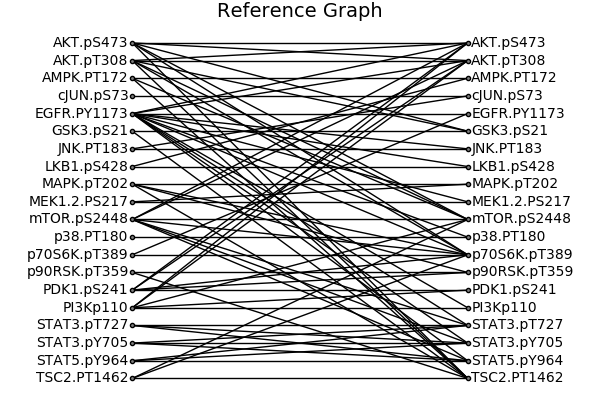

In [18]:
p = visualize_digraph(reference_dg, protein_vec)
Plots.title!(p, "Reference Graph")

In [20]:
function animate_dbn_sampling(dg::DiGraph, v_labels, model, model_args, observations, proposal, proposal_args, 
                              involution, n_samples, thinning, title, gif_file_name)
   
    tr, _ = Gen.generate(model, model_args, observations)
    anim = @animate for i=1:n_samples
        for t=1:thinning
            tr, _ = Gen.metropolis_hastings(tr, proposal, proposal_args, involution)
        end
        p = visualize_digraph(tr[:G], v_labels)
        curtitle = replace(title, "__SAMPLES__"=>i)
        Plots.title!(p, curtitle)
        if i%thinning == 0
            println(i, " steps completed")
        end
    end 
    gif(anim, gif_file_name)
    
end


function animate_dbn_sampling_density(dg::DiGraph, v_labels, model, model_args, observations, proposal, proposal_args, involution, 
                                      n_samples, thinning, median_weight, title, gif_file_name)
    
    tr, _ = Gen.generate(model, model_args, observations)
    count_dict = Dict()
    
    anim = @animate for i=1:n_samples
        
        for t=1:thinning
            tr, _ = Gen.metropolis_hastings(tr, proposal, proposal_args, involution)
        end
        
        G = tr[:G]
        for j=1:size(G.edges)[1]
            e = G.edges[j,:]
            count_dict[e] = get(count_dict, e, 0) + 1
        end
        
        weight_dict = Dict([e => (1.0*count/i)^(-1.0/log2(median_weight)) for (e, count) in count_dict])
        #println(weight_dict)
        p = visualize_digraph_weighted(G, weight_dict, v_labels)
        curtitle = replace(title, "__SAMPLES__"=>i)
        Plots.title!(p, curtitle)
    end
       
    fig = gif(anim, gif_file_name)
    
    return count_dict
end
   

function graph_diff(new_g::DiGraph{T}, old_g::DiGraph{T}) where T
    new_e = Set([new_g.edges[i,:] for i=1:size(new_g.edges)[1]])
    old_e = Set([old_g.edges[i,:] for i=1:size(old_g.edges)[1]])
    
    new_exc = setdiff(new_e, old_e)
    old_exc = setdiff(old_e, new_e)
    if length(new_exc) > 0 && length(old_exc) == 0
        return "add", first(new_exc)
    elseif length(old_exc) > 0 && length(new_exc) == 0
        return "remove", first(old_exc)
    elseif length(old_exc) > 0 && length(new_exc) > 0
        return "reverse", (first(old_exc), first(new_exc))
    else
        return "none", nothing
    end
end


function animate_dbn_exploration(dg::DiGraph, v_labels, model, model_args, observations, proposal, proposal_args, 
                                 involution, n_iterations, title, gif_file_name)
    
    v = sort(collect(dg.vertices))
    ys = length(v):-1:1
    y_dict = Dict([vert => ys[i] for (i,vert) in enumerate(v)])
    xs = [1.0, length(v)]
    
    tr, _ = Gen.generate(model, model_args, observations)
    rejections = 0
    anim = @animate for i=1:n_iterations
        old_G = copy(tr[:G])
        tr, acc = Gen.metropolis_hastings(tr, proposal, proposal_args, involution)
        if !acc
            rejections += 1
        end
        new_G = tr[:G]
        p = visualize_digraph(new_G, v_labels)
        curtitle = replace(title, "__STEPS__"=>i)
        curtitle = replace(curtitle, "__REJECTIONS__"=>rejections)
        Plots.title!(p, curtitle)
        diffstr, e = graph_diff(new_G, old_G)
        if diffstr == "add"
            plot!(p, xs, [y_dict[e[1]]; y_dict[e[2]]], color=:blue, lw=4.0)
        elseif diffstr == "remove"
            plot!(p, xs, [y_dict[e[1]]; y_dict[e[2]]], color=:red, lw=4.0)
        elseif diffstr == "reverse"
            plot!(p, xs, [y_dict[e[1][1]]; y_dict[e[1][2]]], color=:yellow, lw=4.0)
            plot!(p, xs, [y_dict[e[2][1]]; y_dict[e[2][2]]], color=:yellow, lw=4.0)
        end
        
    end
    fig = gif(anim, gif_file_name)
    
    return 1.0*rejections/n_iterations
end

animate_dbn_exploration (generic function with 1 method)

# TESTING BELOW...

In [21]:
#@gen function prior_model(lambda::Float64)
#    @trace(graphprior(lambda, reference_dg), :G)
#    return
#end

In [35]:
lambda = 3.0
n_steps = 1000

observations = Gen.choicemap()
observations[:X] = ts_vec
observations[:lambda] = 3.0

med_indegs = [2.0]
regression_deg_max = 4
rejection_rates = []
thinnings = [1000]
n_samples = 100

100

In [ ]:
# for med_indeg in med_indegs
#     rr = animate_dbn_exploration(reference_dg, protein_vec, full_model, (ts_vec, reference_dg, regression_deg_max), 
#                                  digraph_proposal, (med_indeg,), 
#                                  digraph_involution, n_steps,
#                                  "Graph Posterior Exploration: __STEPS__ steps (__REJECTIONS__ rejected)",
#                                  "posterior-explore-indeg$(med_indeg)-steps$(n_steps)-lambda$(lambda).gif");
#     push!(rejection_rates, rr)
# end

In [ ]:
# for thinning in thinnings
#     animate_dbn_sampling(reference_dg, protein_vec, full_model, (ts_vec, reference_dg, regression_deg_max), 
#                          digraph_proposal, (2.0,), 
#                          digraph_involution, n_samples, thinning,
#                          "DBN Posterior Sampling: __SAMPLES__ samples",
#                          "posterior-sample-samples$(n_samples)-thinning$(thinning)-lambda$(lambda).gif"
#                         );
# end

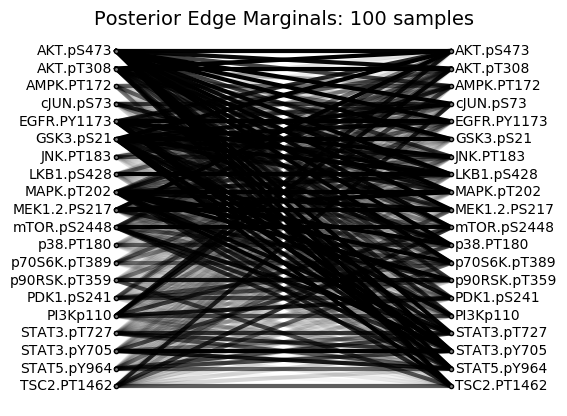

┌ Info: Saved animation to 
│   fn = /home/dmerrell/projects/graph-ppl/julia-project/posterior-density-samples100-thinning1000-lambda3.0.gif
└ @ Plots /home/dmerrell/.julia/packages/Plots/Iuc9S/src/animation.jl:95


In [37]:
for thinning in thinnings
    animate_dbn_sampling_density(reference_dg, protein_vec, full_model, (ts_vec, reference_dg, regression_deg_max),
                                 observations,
                                 digraph_proposal, (2.0,), 
                                 digraph_involution, n_samples, thinning, 0.50,
                                 "Posterior Edge Marginals: __SAMPLES__ samples",
                                 "posterior-density-samples$(n_samples)-thinning$(thinning)-lambda$(lambda).gif");
end

In [ ]:
# function simple_sampling(dg, model, model_args, proposal, proposal_args,
#                          involution, n_samples, thinning)
    
#     tr, _ = Gen.generate(model, model_args)
#     for i=1:n_samples
#         for t=1:thinning
#             tr, _ = Gen.metropolis_hastings(tr, proposal, proposal_args, involution)
#         end
#     end        
# end    

In [ ]:
# @time begin
#     simple_sampling(reference_dg, dumb_model, (3.0,), digraph_proposal, (2.0,), digraph_involution,
#                        1000, 100)
# end